# Black-Box Stoichiometry

## Purpose

* To double check that our flux balance analysis solutions obey black box atom balances before we head on to thermodynamics

* To compare the maximum theoretical yields calculated through FBA to those calculated through black box stoichiometry alone

## Import FBA Results and Stoichiometric Matrix

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
#Read in csv
solution = pd.read_csv('FBA_results/aerobic.csv' , index_col = 0)
solution_glu = pd.read_csv('FBA_results/aerobic_glutamate.csv' , index_col = 0)
#Extract the exchange fluxes
solution_exchanges = solution[solution.index.str.contains('EX_')]
solution_glu_exchanges = solution_glu[solution_glu.index.str.contains('EX_')]
#FBA returned some fluxes that are near-zero but not zero because of double roundoff errors.
solution_exchanges = solution_exchanges.query('abs(fluxes) > .0000000001')
solution_glu_exchanges = solution_glu_exchanges.query('abs(fluxes) > .0000000001')
#Convert the indexes into just the species name, without EX_ or _e
solution_index = [re.search(r"_[^_]+_{1}",i).group() for i in solution_exchanges.index]
solution_index = [i[1:len(i)-1] for i in solution_index]
solution_exchanges.index = solution_index
solution_glu_index = [re.search(r"_[^_]+_{1}",i).group() for i in solution_glu_exchanges.index]
solution_glu_index = [i[1:len(i)-1] for i in solution_glu_index]
solution_glu_exchanges.index = solution_glu_index
#Read in stoichiometries of our exchanged metabolites
S = pd.read_excel('exchange_stoichiometries.xls' , index_col = 0)

In [3]:
print('Stoichiometric Matrix')
display(S)
print('Aerobic Solution Exchange Fluxes (mM/min)')
display(solution_exchanges.T)
print('Aerobic + Glutamate Solution Exchange Fluxes (mM/min)')
display(solution_glu_exchanges.T)

Stoichiometric Matrix


,co2,for,glc,glu,h,h2o,o2,levdopa,nh4
c,1,1,6,5,0,0,0,9,0
h,0,1,12,8,1,2,0,11,4
o,2,2,6,4,0,1,2,4,0
n,0,0,0,1,0,0,0,1,1


Aerobic Solution Exchange Fluxes (mM/min)


,co2,glc,h,h2o,nh4,o2,levdopa
fluxes,14.259281,-10.0,5.082302,39.670791,-5.082302,-14.259281,5.082302


Aerobic + Glutamate Solution Exchange Fluxes (mM/min)


,co2,for,glc,glu,h,h2o,nh4,o2,levdopa
fluxes,659.676219,484.244776,-10.0,-494.748259,-350.827264,442.30209,340.323781,-654.424478,154.424478


## Balance Checking

Now, we'll verify that all elemental balances are satisfied for each of our flux balance analysis solutions. (Checking all elemental balances will also ensure our redox balance works out!)

A valid flux solution $q$ will satisfy $Sq=0$, where $S$ is the species stoichiometric matrix.

In [4]:
print('Aerobic Solution Element Balance (mM/min)')
display(S[solution_exchanges.index] @ solution_exchanges)

Aerobic Solution Element Balance (mM/min)


,fluxes
c,-4.440892e-15
h,-4.174439e-14
o,-7.105427e-15
n,0.000000e+00


In [5]:
print('Aerobic Solution + Glutamate Element Balance (mM/min)')
display(S[solution_glu_exchanges.index] @ solution_glu_exchanges)

Aerobic Solution + Glutamate Element Balance (mM/min)


,fluxes
c,7.105427e-13
h,1.222134e-12
o,-1.136868e-13
n,8.526513e-14


In conclusion, it looks like all of our elemnental balances are closed within floating point arithemtic error!

## Black-Box Maximum Theoretical Pathway Yield

Before "opening the box" and looking into pathway details, what is the maximum yield of levdopa from glucose (and either glutamate or ammonia as a carbon source?)

We'll determine this by balancing our reaction using matrices. We'll obtain a stoichiometric matrix $S$ of glucose, levdopa, and water, ammonia, and carbon dioxide to balance the pathway as redox-neutral compounds. We know that we can multiply this stocihiometry matrix by a flux vector $q$ such that $Sq=0$.

We'll balance this reaction by splitting our stoichiometry matrix into $S_{meas}$ and $S_{calc}$. We'll define our $S_{meas}$ to contain only glucose, and we'll define its flux to be -1. Then, our $S_{calc}$ will contain levdopa, water, ammonia, and carbon dioxide and should be invertible. We can then calculate the fluxes of the calculated species as $q_{calc}=-S_{calc}^{-1}S_{meas}q_{meas}$.

In [6]:
S_meas = S[['glc']]
S_calc = S[['h2o','nh4','levdopa','co2']]
#Change our stoichiometry matrix to ammonia, not ammonium. Ammonium was used by the BiGG model for FBA,
#but is not redox-neutral for this analysis!
S_calc.at['h','nh4'] = 3
S_calc.columns = ['h2o','nh3','levdopa','co2']
v_meas = pd.DataFrame(np.array([-1]) , index = ['glc'])
v_calc = -1* np.linalg.inv(S_calc) @ S_meas @ v_meas
v_calc.index = ['h2o','nh3','levdopa','co2']
v_calc.columns = ['Flux']
v_calc

,Flux
h2o,3.333333
nh3,-0.666667
levdopa,0.666667
co2,0.000000


$3\ Glucose + 2\ NH_3 \rightarrow 10\ H_2O + 2\ levdopa$.

Our maximum theoretical yield coefficients are therefore:

$Y_{ldopa/glu}=0.667\ mol/mol=1\ cmol/cmol$

$Y_{ldopa/NH3}=1\ mol/mol$

Now, what if glutamate is our nitrogen source instead of ammonia?

In [7]:
S_meas = S[['glc']]
S_calc = S[['h2o','glu','levdopa','co2']]
#Use the neutral glutamaic acid, not the glutamate anion, for this initial black box balancing.
S_calc.at['h','glu'] = S_calc.at['h','glu'] + 1
S_calc.columns = ['h2o','glu','levdopa','co2']
v_meas = pd.DataFrame(np.array([-1]) , index = ['glc'])
v_calc = -1* np.linalg.inv(S_calc) @ S_meas @ v_meas
v_calc.index = ['h2o','glu','levdopa','co2']
v_calc.columns = ['Flux']
v_calc

,Flux
h2o,4.666667
glu,-1.333333
levdopa,1.333333
co2,0.666667


$3\ Glucose + 4\ Glu \rightarrow 2\ CO_2 + 14\ H_2O + 4\ levdopa$.

Our maximum theoretical yield coefficients are therefore:

$Y_{ldopa/glu}=1.33\ mol/mol$

$Y_{ldopa/total\ carbon\ input}=0.947\ cmol/cmol$

$Y_{ldopa/glu}=1\ mol/mol$

# Make some extra plots for the presentation

In [8]:
import seaborn as sns
sns.set(style="whitegrid")

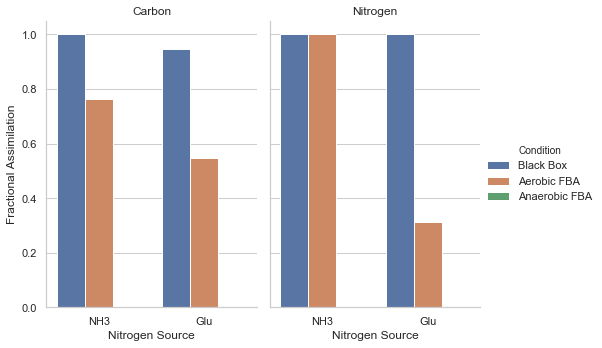

In [9]:
d = pd.DataFrame(data = zip([1, 0.947 , 0.762345 , 0.548525 , 1, 1 , 1 , 0.312127 , 0 , 0], 
                            ['NH3', 'Glu' , 'NH3', 'Glu' , 'NH3', 'Glu' , 'NH3', 'Glu' , 'NH3' , 'NH3'] , 
                            ['Black Box' , 'Black Box' , 'Aerobic FBA' , 'Aerobic FBA' , 'Black Box' , 'Black Box' , 'Aerobic FBA' , 'Aerobic FBA' , 'Anaerobic FBA' , 'Anaerobic FBA'],
                            ['Carbon','Carbon','Carbon','Carbon','Nitrogen','Nitrogen','Nitrogen','Nitrogen' , 'Carbon' , 'Nitrogen']),
                 columns = ['Fractional Assimilation' , 'Nitrogen Source' , 'Condition' , 'Element'])

p = sns.catplot(x="Nitrogen Source", y="Fractional Assimilation",
                 hue="Condition", col="Element",
                 data=d, kind="bar",aspect=.7).set_titles('{col_name}');
p.fig.savefig('figures/blackboxvsfba.png', dpi = 600)


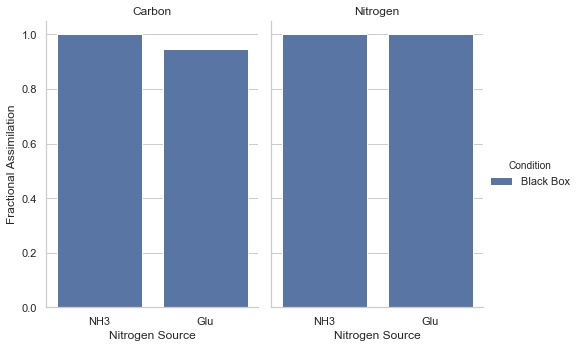

In [10]:
d1 = d.query("Condition == 'Black Box'")
p = sns.catplot(x="Nitrogen Source", y="Fractional Assimilation",
                 hue="Condition", col="Element",
                 data=d1, kind="bar",aspect=.7).set_titles('{col_name}');
p.fig.savefig('figures/blackbox.png', dpi = 600)